In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
from pprint import pprint
import os
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Scraping from allmenus.com

In [45]:
url = 'https://www.allmenus.com/ny/new-york/368140-somtum-der/menu/'
r = requests.get(url)
page = r.text
soup = BeautifulSoup(page)

/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [46]:
somtumder_menu = {}

for item in soup.find_all(class_='menu-items'):
    somtumder_menu[item.find(class_='item-title').text] = (item.find(class_='description').text,
                                                           item.find(class_='item-price').text.strip())
    

# Scraping from menupages.com

In [8]:
url3 = 'https://menupages.com/somtum-der/85-ave-a-new-york'
r3 = requests.get(url3)
page3 = r3.text
soup3 = BeautifulSoup(page3, 'html.parser')

In [71]:
somtumder_menu_2 = {}

for item in soup3.find_all(class_='menu-item'):
    dish = item.find(class_='menu-item__title').text
    if item.find(class_='menu-item__description') is None:
        desc = ''
    else:
        desc = item.find(class_='menu-item__description').text.strip()
    price = item.find(class_='menu-item__price').text.strip()
    somtumder_menu_2[dish] = (desc, price)

In [43]:
soup3.find_all(class_='restaurant-phone')[0].find('a')['href'].replace('tel:','')

'+12122608570'

In [44]:
def get_site_pages(page_list, n_pages):
    for i in range(2, n_pages+1):
        page_list.append('https://menupages.com/restaurants/ny-new-york/'+str(i))
    return page_list


def get_menu_urls(page_list):
    menu_urls = []
    for page in page_list:
        r = requests.get(page)
        txt = r.text
        soup = BeautifulSoup(txt, 'html.parser')
        for item in soup.find_all(class_='restaurant__title'):
            menu_urls.append('https://menupages.com'+item.find('a')['href'])
    return menu_urls

In [45]:
page_list = get_site_pages(['https://menupages.com/restaurants/ny-new-york'], 86)
menu_urls = get_menu_urls(page_list)

In [51]:
def get_phone(menu_urls):
    phone_book = {}
    
    for menu in menu_urls:
        r = requests.get(menu)
        txt = r.text
        soup = BeautifulSoup(txt, 'html.parser')
        
        name = soup.find_all(class_='header__restaurant-name')
        if len(name) == 0:
            continue
        
        phone_book['name'] = name[0].text.strip()
        phone_book['phone'] = soup.find_all(class_='restaurant-phone')[0].find('a')['href'].replace('tel:','')
    
        print(phone_book['name'])
        print(phone_book['phone'])
    return phone_book

In [52]:
get_phone(menu_urls)

"Pulled & Chopped"  BBQ Sandwiches & Bowls
+16468959232
"SVK" Sous Vide Kitchen
+16468959232
# Wrapido (23rd St.)
+12129299300
# Wrapido (8th Ave)
+12129293287
#1A Canaan Sushi
+12129479298
#Healthy by Sunburst
+13474593153
1 Bite Grill
+12127535057
1 Up Bistro
+19174920697
105 Deli & Grill
+12128662297
107 West
+12128641555
108 Food Dried Hot Pot
+19176756878
109 Spicy Gourmet Deli
+12122807329
10th Avenue Pizza & Cafe
+12123669222
11 Hanover Greek
+12127854000
118 Kitchen
+12127226888
11B Express
+12123889811
11th Street Cafe
+16466924455
12 Chairs (SoHo)
+12122548640
16 Handles
+12126272808
16 Handles
+12122604414


KeyboardInterrupt: 

# Getting Yelp data from API using phone number

In [4]:
with open('data/menus_new.json') as f:
    data = json.load(f)

In [5]:
restaurant_list = [rest['name'] for rest in data]

In [6]:
restaurant_list

['"Pulled & Chopped"  BBQ Sandwiches & Bowls',
 '"SVK" Sous Vide Kitchen',
 '# Wrapido (23rd St.)',
 '# Wrapido (8th Ave)',
 '#1A Canaan Sushi',
 '#Healthy by Sunburst',
 '1 Bite Grill',
 '1 Up Bistro',
 '105 Deli & Grill',
 '107 West',
 '108 Food Dried Hot Pot',
 '109 Spicy Gourmet Deli',
 '10th Avenue Pizza & Cafe',
 '11 Hanover Greek',
 '118 Kitchen',
 '11B Express',
 '11th Street Cafe',
 '12 Chairs (SoHo)',
 '16 Handles',
 '16 Handles',
 '16 Handles',
 '16 Handles -  UWS Amsterdam',
 '16 Handles - UES 1ST AVE',
 '16 Handles - UES 2ND AVE',
 '16 Handles - UWS Broadway',
 '164 Presbyterian Deli',
 '165 NY Presbyterian Deli',
 '172 Presbyterian Deli',
 '1742 Pizza',
 '178 Taco House',
 '1803',
 '181 Cabrini',
 '1983 Gourmet Deli',
 '1st Ave Gourmet Deli',
 '2 Bros Pizza',
 '2 Bros Pizza',
 '2 Bros Pizza',
 '2 Bros Pizza',
 '21 Shanghai House',
 '211 New Taco Grill',
 '212 Steakhouse',
 '22 Thai Cuisine',
 '251 Ginza Sushi Huang',
 '28 Sushi',
 '2Beans',
 '2Beans Chelsea',
 "3 Bro's 99

In [7]:
phone_list = [rest['phone'] for rest in data]

In [75]:
phone_list

['+16468959232',
 '+16468959232',
 '+12129299300',
 '+12129293287',
 '+12129479298',
 '+13474593153',
 '+12127535057',
 '+19174920697',
 '+12128662297',
 '+12128641555',
 '+19176756878',
 '+12122807329',
 '+12123669222',
 '+12127854000',
 '+12127226888',
 '+12123889811',
 '+16466924455',
 '+12122548640',
 '+12126272808',
 '+12122604414',
 '+12122131755',
 '+16468611281',
 '+16467073424',
 '+16468632522',
 '+16464227022',
 '+12125683130',
 '+12125432119',
 '+12126851230',
 '+12124271010',
 '+12123931026',
 '+12122673000',
 '+12129232233',
 '+12122345609',
 '+12124728480',
 '+12122391117',
 '+12127770600',
 '+12126752922',
 '+12126952642',
 '+12122268998',
 '+12123533728',
 '+12128580646',
 '+12127329250',
 '+12128893333',
 '+12126851525',
 '+12129378914',
 '+12129378914',
 '+17185453330',
 '+12123881264',
 '+12122217831',
 '+12124757420',
 '+12123483800',
 '+16466492054',
 '+12128617500',
 '+12123751114',
 '+12129041351',
 '+12126890316',
 '+12126431900',
 '+16469467604',
 '+12129490245

In [77]:
headers = {'Authorization': 'bearer %s' % os.environ['YELP_API_KEY']}
biz_data = []

for i, phone in enumerate(phone_list):
    print(i)
    params = {'phone': phone}
    r = requests.get('https://api.yelp.com/v3/businesses/search/phone',
                     params=params, headers=headers)
    biz_data.append(r.json())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [78]:
with open('data/biz_data.json', 'w') as f:
    json.dump(biz_data, f)

In [9]:
with open('data/biz_data.json') as f:
    biz_data = json.load(f)

In [73]:
cleaned_biz_data = biz_data.copy()

for i, biz in enumerate(cleaned_biz_data):
    for j, listing in enumerate(biz['businesses']):
        if listing['location']['state'] != 'NY':
            print(listing['location']['state'])
            del biz['businesses'][j]
    if len(biz['businesses']) == 0:
        del cleaned_biz_data[i]

Astoria
Manhattan
Manhattan
Manhattan
Manhattan
Manhattan
Manhattan
Astoria
Manhattan
New York City
Manhattan
Queens
Manhattan
Astoria
Hoboken
Oakland Gardens
Union Square
Manhattan
Rockaway Park
Brooklyn
Astoria
Manhattan
New  York
Manhattan
New York City
Manhattan
Brooklyn
New York City
Manhattan
Manhattan
San Francisco
Williamsburg
Manhattan
Woodside
Crown Heights
Manhattan
Harlem
Brooklyn
Manhattan
Bronx
New York City
Elmhurst
Manhattan
New York City
Brooklyn
Manhattan
Manhattan
Flat Iron
Manhattan
Manhattan
Akron
Baltimore
Minneapolis
Birmingham
Syracuse
Chicago
Knoxville
Tucson
Norman
Atlanta
Akron
Baltimore
Minneapolis
Birmingham
Syracuse
Chicago
Knoxville
Tucson
Norman
Atlanta
Manhattan
Manhattan
Greenwich
Boston
Long Island City
Brooklyn
Las Vegas
Chicago
Brooklyn
Wayne
West Caldwell
Chicago
Chicago
Chicago
Brooklyn
Wayne
West Caldwell
Chicago
Chicago
Chicago
Brooklyn
Wayne
West Caldwell
Chicago
Chicago
Chicago
Brooklyn
Wayne
West Caldwell
Chicago
Chicago
Chicago
Brooklyn
Wayn

In [ ]:
with open('data/cleaned_biz_data.json', 'w') as f:
    json.dump(cleaned_biz_data, f)

In [71]:
biz_data[0]

{'businesses': [{'id': 'HkTeodZ690Lkukhui4INlA',
   'alias': 'bonmi-new-york-3',
   'name': 'BONMi',
   'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/np65bQHH7HEFmfnzfLl8eA/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/bonmi-new-york-3?adjust_creative=klKOH0vt-WoS8zdLdqbd8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=klKOH0vt-WoS8zdLdqbd8w',
   'review_count': 92,
   'categories': [{'alias': 'vietnamese', 'title': 'Vietnamese'},
    {'alias': 'coffee', 'title': 'Coffee & Tea'},
    {'alias': 'sandwiches', 'title': 'Sandwiches'}],
   'rating': 4.0,
   'coordinates': {'latitude': 40.73995, 'longitude': -73.98538},
   'transactions': ['delivery', 'pickup'],
   'price': '$$',
   'location': {'address1': '119 E 23rd St',
    'address2': '',
    'address3': None,
    'city': 'New York',
    'zip_code': '10010',
    'country': 'US',
    'state': 'NY',
    'display_address': ['119 E 23rd St', 'New York, NY 10010']},
   'phone': '+16468959232'

In [11]:
totals = [biz['total'] for biz in biz_cleaned]

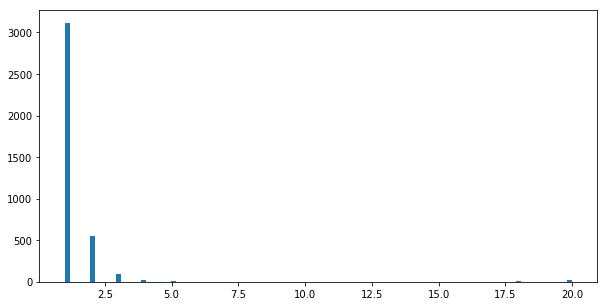

In [14]:
plt.figure(figsize=(10,5))
plt.hist(totals, bins=100);

In [31]:
for i, biz in enumerate(biz_cleaned):
    if biz['total'] > 5:
        print(i)

1671
1672
1762
1763
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
2234
3727
3728
3729
3730


In [35]:
biz_cleaned[3730]

{'businesses': [{'id': 'sJj6R4sz61PM9l-etK_WIA',
   'alias': 'wichcraft-manhattan-9',
   'name': "'wichcraft",
   'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/04Ch1-SeAGd0cWHw7f73xg/o.jpg',
   'is_closed': True,
   'url': 'https://www.yelp.com/biz/wichcraft-manhattan-9?adjust_creative=klKOH0vt-WoS8zdLdqbd8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=klKOH0vt-WoS8zdLdqbd8w',
   'review_count': 16,
   'categories': [{'alias': 'sandwiches', 'title': 'Sandwiches'}],
   'rating': 3.5,
   'coordinates': {'latitude': 40.7402150800983,
    'longitude': -73.973960940825},
   'transactions': [],
   'price': '$$',
   'location': {'address1': '440 E 29th St',
    'address2': '',
    'address3': '',
    'city': 'Manhattan',
    'zip_code': '11210',
    'country': 'US',
    'state': 'NY',
    'display_address': ['440 E 29th St', 'Manhattan, NY 11210']},
   'phone': '+12127800577',
   'display_phone': '(212) 780-0577'},
  {'id': '_dJBogcWfMC2Fe2Um0PntA',
   'alias': '

In [87]:
urls = [biz_cleaned[0]['businesses'][i]['url'] for i in range(biz_cleaned[0]['total'])]

In [88]:
urls

['https://www.yelp.com/biz/sous-vide-kitchen-a-virtual-food-hall-new-york?adjust_creative=klKOH0vt-WoS8zdLdqbd8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=klKOH0vt-WoS8zdLdqbd8w',
 'https://www.yelp.com/biz/bonmi-new-york-3?adjust_creative=klKOH0vt-WoS8zdLdqbd8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=klKOH0vt-WoS8zdLdqbd8w',
 'https://www.yelp.com/biz/pulled-and-chopped-bbq-sandwiches-and-bowls-new-york?adjust_creative=klKOH0vt-WoS8zdLdqbd8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=klKOH0vt-WoS8zdLdqbd8w']

In [15]:
yelp_urls = []
for biz in biz_cleaned:
    yelp_urls.append([biz['businesses'][i]['url'] for i in range(biz['total'])])

In [24]:
flat_urls = [url for restaurant in yelp_urls for url in restaurant]

In [27]:
len(flat_urls)
len(set(flat_urls))

4595

In [28]:
set(flat_urls)

{'https://www.yelp.com/biz/blue-coco-new-york?adjust_creative=klKOH0vt-WoS8zdLdqbd8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=klKOH0vt-WoS8zdLdqbd8w',
 'https://www.yelp.com/biz/curry-ya-new-york-4?adjust_creative=klKOH0vt-WoS8zdLdqbd8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=klKOH0vt-WoS8zdLdqbd8w',
 'https://www.yelp.com/biz/subway-new-york-41?adjust_creative=klKOH0vt-WoS8zdLdqbd8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=klKOH0vt-WoS8zdLdqbd8w',
 'https://www.yelp.com/biz/hale-and-hearty-soups-new-york-19?adjust_creative=klKOH0vt-WoS8zdLdqbd8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=klKOH0vt-WoS8zdLdqbd8w',
 'https://www.yelp.com/biz/acerra-brick-oven-pizza-new-york?adjust_creative=klKOH0vt-WoS8zdLdqbd8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_phone_search&utm_source=klKOH0vt-WoS8zdLdqbd8w',
 'https://www.yelp.com/biz/claw-daddys-new-york?adjust_creative=klKOH0vt-WoS8zdLdqbd8

In [23]:
len(yelp_urls)

3814